In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import cv2
import shutil
from shutil import copyfile
import path

In [2]:
predict_dir = '/kaggle/working/predict'
label_dir = '/kaggle/working/runs/detect/exp/labels'
image_dir = '/kaggle/working/runs/detect/exp'

In [3]:
# Make a dir to export jpgs to
if not os.path.exists(f'{predict_dir}'):
    os.mkdir(f'{predict_dir}')

In [4]:
# Copy YOLO
if not os.path.exists('/kaggle/working/yolov5'):
    shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')

In [5]:
# This function gives a basic plane from the ImageOrientationPatient tag. It doesn't account for obliqueness. But we don't need to care about it.
# Will return 'unknown' if the image isn't exactly orthogonal.
def get_image_plane(loc):
    row_x = round(loc[0])
    row_y = round(loc[1])
    row_z = round(loc[2])
    col_x = round(loc[3])
    col_y = round(loc[4])
    col_z = round(loc[5])
    if (row_x, row_y, col_x, col_y) == (1,0,0,0):
        return "coronal"
    if (row_x, row_y, col_x, col_y) == (0,1,0,0):
        return "sagittal"
    if (row_x, row_y, col_x, col_y) == (1,0,0,1):
        return "axial"
    return "Unknown"

In [6]:
# Call yolo detect.py on an image
def detect(plane):
    !python yolov5/detect.py --source {predict_dir} --weights ../input/brain-tumor-yolo-od/{plane}_t1wce_2_class.pt --img 512 --exist-ok --save-txt

In [7]:
# Delete all images and labels
def cleanup():
    if os.path.exists(label_dir):
        filelist = [ f for f in os.listdir(label_dir) if f.endswith(".txt") ]
        for f in filelist:
            os.remove(os.path.join(label_dir, f))

        filelist = [ f for f in os.listdir(image_dir) if f.endswith(".jpg") ]
        for f in filelist:
            os.remove(os.path.join(image_dir, f))
            
    filelist = [ f for f in os.listdir(predict_dir) if f.endswith(".jpg") ]
    for f in filelist:
        os.remove(os.path.join(predict_dir, f))  

In [8]:
def detect_tumor(study, image_number):

    # Make sure there aren't files hanging around from the last run
    cleanup()

    # Load an image
    image = pydicom.dcmread(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{study}/T1wCE/Image-{image_number}.dcm')
    pixels = image.pixel_array

    # Crunch pixels down to 8 bit
    pixels = pixels - np.min(pixels)
    pixels = pixels / np.max(pixels)
    pixels = (pixels * 255).astype(np.uint8)

    # Get the plane
    plane = get_image_plane(image.ImageOrientationPatient)
    print("Plane:", plane)

    # Expor the image as a JPG
    filename = f'{predict_dir}/{study}_t1wce_{image_number}.jpg'
    cv2.imwrite(filename, pixels)
    
    # Run YOLO detect on the exported image
    detect(plane)
    
    # Get the YOLO image and label/BB coords .. if they exist
    image_name = f'{image_dir}/{study}_t1wce_{image_number}.jpg'
    if os.path.isfile(image_name):
        img = cv2.imread(image_name)

        label_name = f'{label_dir}/{study}_t1wce_{image_number}.txt'
        if os.path.isfile(label_name):
            label_file = open(label_name, "r")
            label_text = label_file.read()

            fig, axes = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False, figsize=(10, 10))
            ax = axes.ravel()
            ax[0].set_title('Original')
            ax[0].imshow(pixels, cmap='gray')
            ax[1].set_title('OD Detect')
            ax[1].imshow(img, cmap='gray')

            plt.tight_layout()
            plt.show()

            print("Label/BB coords:", label_text)
        else:
            plt.figure(figsize= (6,6))
            plt.title('No Tumor Detected')
            plt.imshow(pixels, cmap='gray');

Plane: axial
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=512, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/kaggle/working/predict', update=False, view_img=False, weights=['../input/brain-tumor-yolo-od/axial_t1wce_2_class.pt'])
Fusing layers... 
image 1/1 /kaggle/working/predict/00216_t1wce_98.jpg: 512x480 1 negatives, Done. (0.276s)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels
Done. (0.307s)


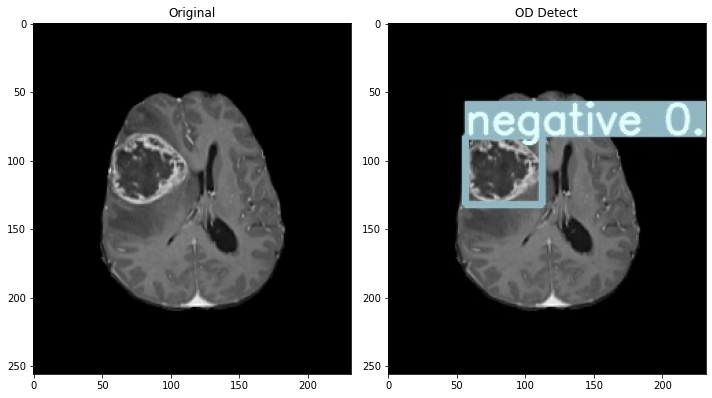

Label/BB coords: 0 0.362069 0.417969 0.241379 0.195312



In [9]:
# Specify a study,series and image number and call the main function
study = '00216'
image_number = '98'

detect_tumor(study, image_number)

Plane: coronal
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=512, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/kaggle/working/predict', update=False, view_img=False, weights=['../input/brain-tumor-yolo-od/coronal_t1wce_2_class.pt'])
Fusing layers... 
image 1/1 /kaggle/working/predict/00006_t1wce_90.jpg: 512x512 1 negatives, 1 positives, Done. (0.263s)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels
Done. (0.274s)


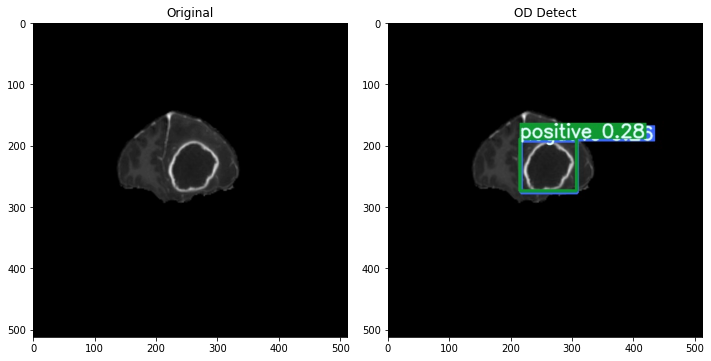

Label/BB coords: 0 0.510742 0.458984 0.177734 0.164062
1 0.507812 0.452148 0.179688 0.166016



In [10]:
study = '00006'
image_number = '90'
detect_tumor(study, image_number)

Plane: sagittal
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=512, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/kaggle/working/predict', update=False, view_img=False, weights=['../input/brain-tumor-yolo-od/sagittal_t1wce_2_class.pt'])
Fusing layers... 
image 1/1 /kaggle/working/predict/00019_t1wce_50.jpg: 512x512 1 negatives, Done. (0.222s)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels
Done. (0.232s)


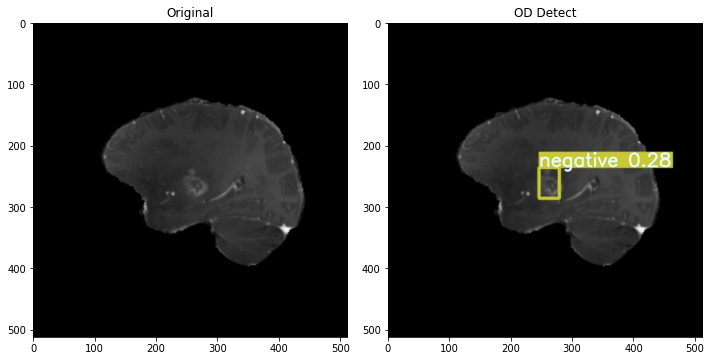

Label/BB coords: 0 0.510742 0.509766 0.0644531 0.0976562



In [11]:
study = '00019'
image_number = '50'
detect_tumor(study, image_number)

Plane: axial
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=512, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/kaggle/working/predict', update=False, view_img=False, weights=['../input/brain-tumor-yolo-od/axial_t1wce_2_class.pt'])
Fusing layers... 
image 1/1 /kaggle/working/predict/00008_t1wce_80.jpg: 512x512 Done. (0.287s)
Results saved to runs/detect/exp
0 labels saved to runs/detect/exp/labels
Done. (0.296s)


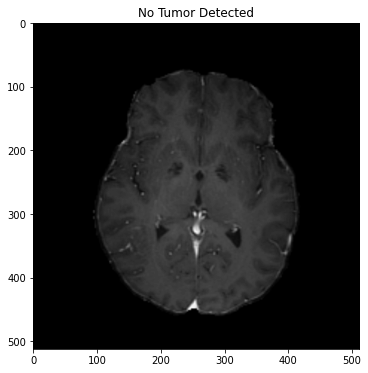

In [12]:
study = '00008'
image_number = '80'
detect_tumor(study, image_number)